# 전력 사용 데이터 분석
### 데이터 사이트
https://www.kaggle.com/uciml/electric-power-consumption-data-set


In [67]:
# 데이터 다운로드

!curl -L https://www.kaggle.com/uciml/electric-power-consumption-data-set/downloads/household_power_consumption.txt -o power.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  9953    0  9953    0     0  11506      0 --:--:-- --:--:-- --:--:-- 11506


In [18]:
!unzip power.zip

Archive:  power.zip
  inflating: household_power_consumption.txt  


In [19]:
# !curl -L https://bit.ly/2RY3gwo -o power.txt

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

In [42]:
df=pd.read_csv('household_power_consumption.txt', delimiter=';')
print('Number of rows and columns:', df.shape)
df.head(5)

Number of rows and columns: (2075259, 9)


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0000
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0000
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0000
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0000
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0000


## 데이터 전처리
- Merge Date & Time into one column and change to datetime type.
- Convert Global_active_power to numeric and remove missing values (1.2%).
- Create year, quarter, month and day features.
- Create weekday feature, “0” is weekend and “1” is weekday.

- 전기 총 사용량을 나타내는 변수명: Global_active_power history

- 아래 전처리에 시간이 오래 걸림 (5분 정도)

In [43]:
df['date_time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df = df.dropna(subset=['Global_active_power'])
df['date_time']=pd.to_datetime(df['date_time']) 
df['year'] = df['date_time'].apply(lambda x: x.year)
df['quarter'] = df['date_time'].apply(lambda x: x.quarter)
df['month'] = df['date_time'].apply(lambda x: x.month)
df['day'] = df['date_time'].apply(lambda x: x.day)
df=df.loc[:,['date_time','Global_active_power', 'year','quarter','month','day']]
df.sort_values('date_time', inplace=True, ascending=True)
df = df.reset_index(drop=True)
df["weekday"]=df.apply(lambda row: row["date_time"].weekday(),axis=1)
df["weekday"] = (df["weekday"] < 5).astype(int)
print('Number of rows and columns after removing missing values:', df.shape)
print('The time series starts from: ', df.date_time.min())
print('The time series ends on: ', df.date_time.max())


Number of rows and columns after removing missing values: (2049280, 7)
The time series starts from:  2006-12-16 17:24:00
The time series ends on:  2010-12-11 23:59:00


## 정규분포 테스트
- D’Agostino’s K² Test 사용


In [39]:
stat, p = stats.normaltest(df.Global_active_power)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')


Statistics=724881.795, p=0.000
Data does not look Gaussian (reject H0)


### Kurtosis and Skewness
- Kurtosis: describes heaviness of the tails of a distribution (0 근처이면 tail이 정규분포에 가깝다. 양수이면 꼬리가 두껍고, 음수이면 꼬리가 가늘다)
- Skewness: measures asymmetry of the distribution (-0.5~0.5 사이이면 좌우대칭에 가깝다. 절대값이 0.5~1 사이이면 약간 skew 되었고, 1 이상이면 크게 skew되었다고 한다.

sns.distplot(df.Global_active_power);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df.Global_active_power)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df.Global_active_power)))

## 그림그리기

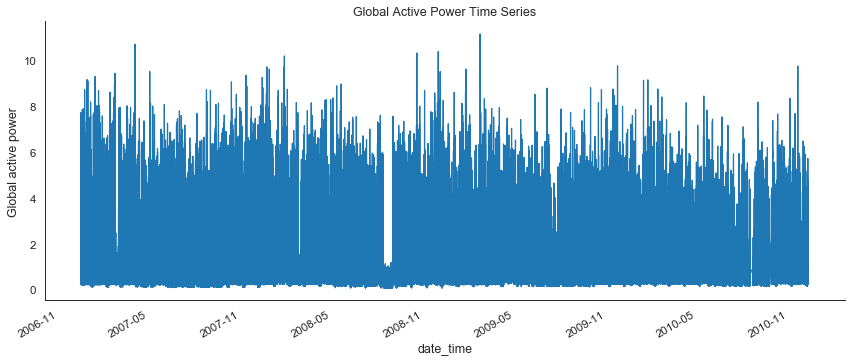

In [26]:
df1=df.loc[:,['date_time','Global_active_power']]
df1.set_index('date_time',inplace=True)
df1.plot(figsize=(12,5))
plt.ylabel('Global active power')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Global Active Power Time Series')
sns.despine(top=True)
plt.show();

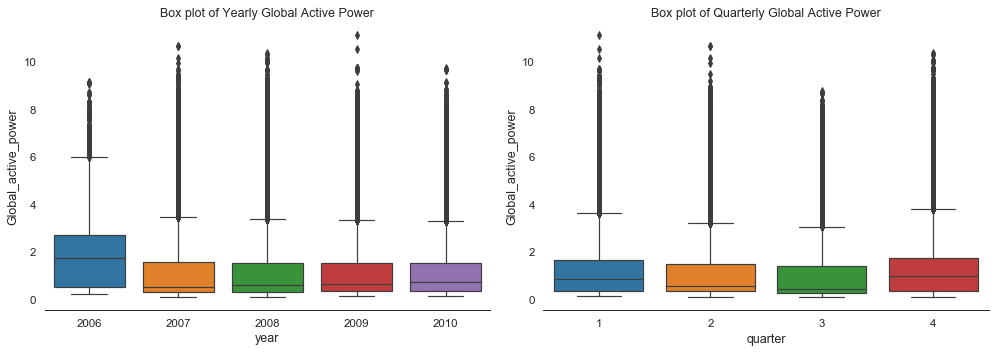

In [27]:
# 박스 플롯
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x="year", y="Global_active_power", data=df)
plt.xlabel('year')
plt.title('Box plot of Yearly Global Active Power')
sns.despine(left=True)
plt.tight_layout()
plt.subplot(1,2,2)
sns.boxplot(x="quarter", y="Global_active_power", data=df)
plt.xlabel('quarter')
plt.title('Box plot of Quarterly Global Active Power')
sns.despine(left=True)
plt.tight_layout();


### 2016년는 12월 데이터만 있다는 것을 주의해야 한다
- 겨울에 전기 사용량이 많다
- 정규 분포와는 거리가 먼 것을 알 수 있다.

,count,mean,std,min,25%,50%,75%,max
Global_active_power,2049280.0000,1.0916,1.0573,0.0760,0.3080,0.6020,1.5280,11.1220


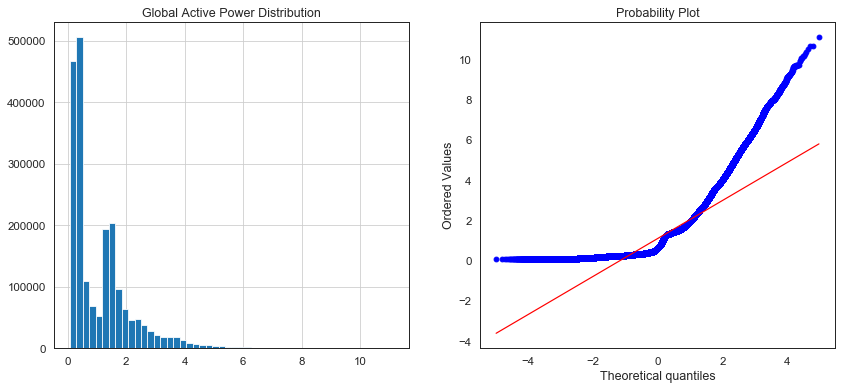

In [28]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df['Global_active_power'].hist(bins=50)
plt.title('Global Active Power Distribution')
plt.subplot(1,2,2)
stats.probplot(df['Global_active_power'], plot=plt);
df1.describe().T

- Average Global Active Power Resampled Over Day, Week, Month, Quarter and Year


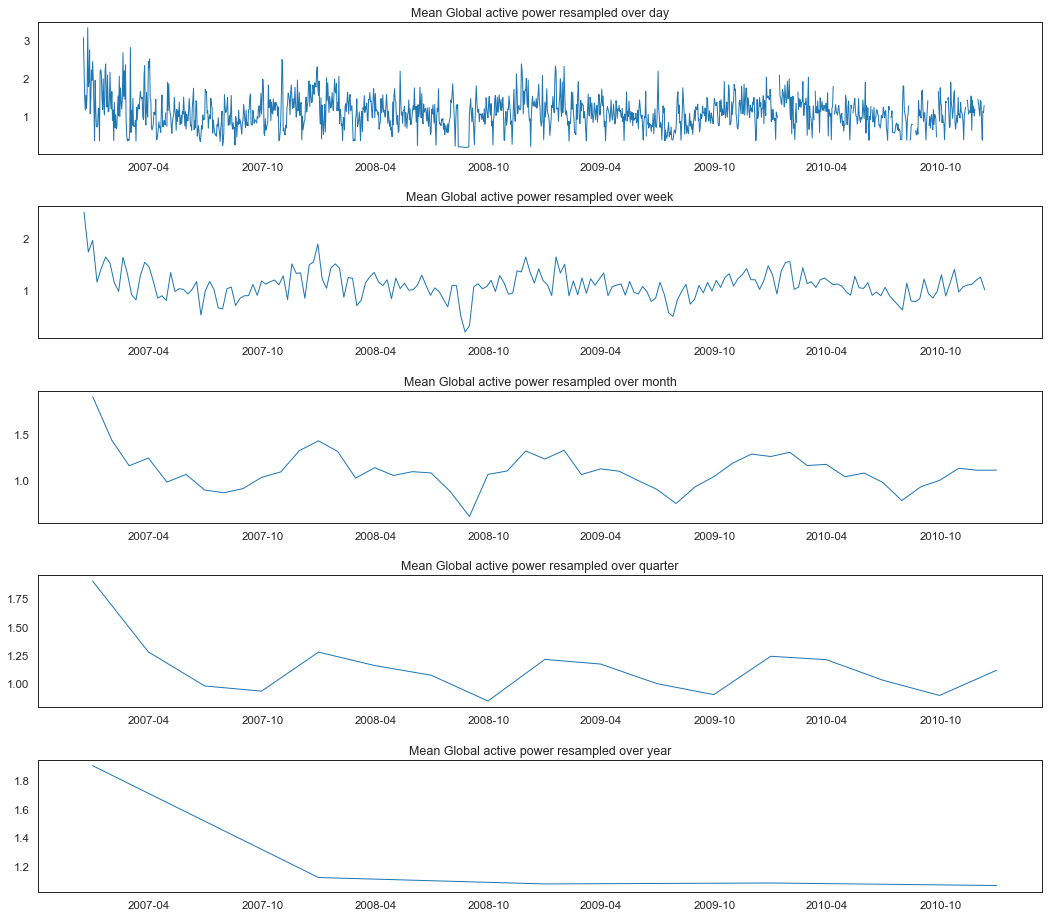

In [29]:
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(5,1,1)
ax1.plot(df1['Global_active_power'].resample('D').mean(),linewidth=1)
ax1.set_title('Mean Global active power resampled over day')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(df1['Global_active_power'].resample('W').mean(),linewidth=1)
ax2.set_title('Mean Global active power resampled over week')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(df1['Global_active_power'].resample('M').mean(),linewidth=1)
ax3.set_title('Mean Global active power resampled over month')
ax3.tick_params(axis='both', which='major')

ax4  = fig.add_subplot(5,1,4, sharex=ax1)
ax4.plot(df1['Global_active_power'].resample('Q').mean(),linewidth=1)
ax4.set_title('Mean Global active power resampled over quarter')
ax4.tick_params(axis='both', which='major')

ax5  = fig.add_subplot(5,1,5, sharex=ax1)
ax5.plot(df1['Global_active_power'].resample('A').mean(),linewidth=1)
ax5.set_title('Mean Global active power resampled over year')
ax5.tick_params(axis='both', which='major');


- 트렌드 변화는 없는 것으로 보인다.
- 2006년에는 12월 데이터만 있다.

## Plot Mean Global Active Power Grouped by Year, Quarter, Month and Day

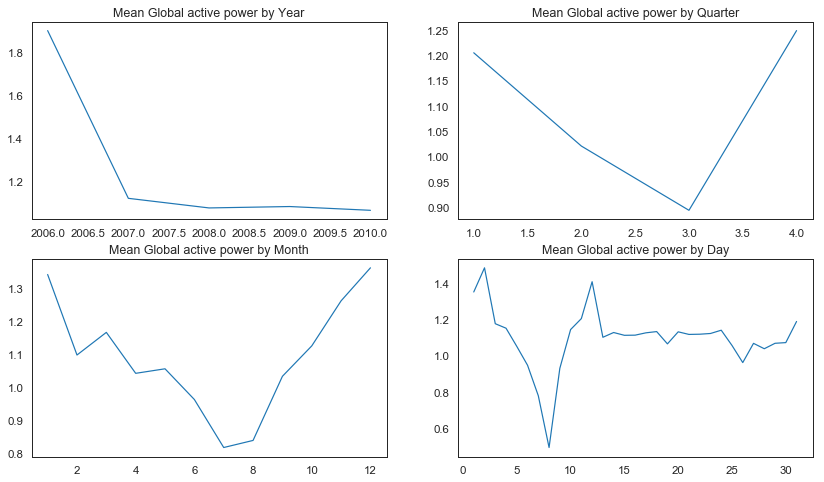

In [31]:
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
df.groupby('year').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Year')

plt.subplot(2,2,2)
df.groupby('quarter').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Quarter')

plt.subplot(2,2,3)
df.groupby('month').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Month')

plt.subplot(2,2,4)
df.groupby('day').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Day');

## Global Active Power by Years

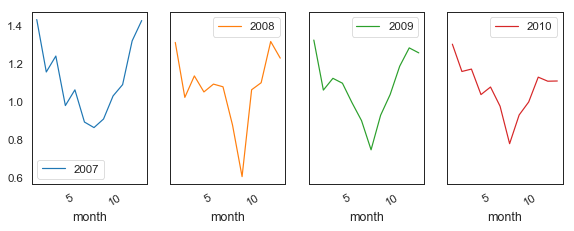

In [32]:
# 2006년 데이터는 제외
pd.pivot_table(df.loc[df['year'] != 2006], values = "Global_active_power", 
               columns = "year", index = "month").plot(subplots = True, figsize=(12, 12), layout=(3, 5), sharey=True);

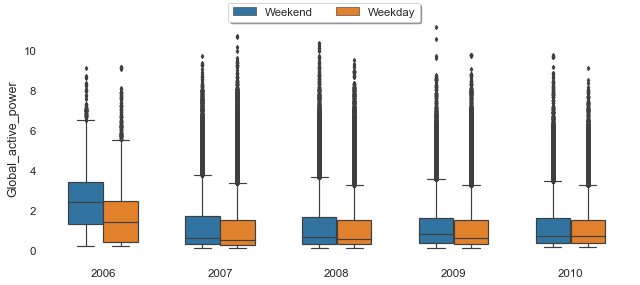

In [33]:
# 주중 주말

dic={0:'Weekend',1:'Weekday'}
df['Day'] = df.weekday.map(dic)
a=plt.figure(figsize=(9,4)) 
plt1=sns.boxplot('year','Global_active_power',hue='Day',width=0.6,fliersize=3,
                    data=df)                                                                                                                                                                                                                                                                                                                                                 
a.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00), shadow=True, ncol=2)
sns.despine(left=True, bottom=True) 
plt.xlabel('')
plt.tight_layout()                                                                                                                  
plt.legend().set_visible(False);

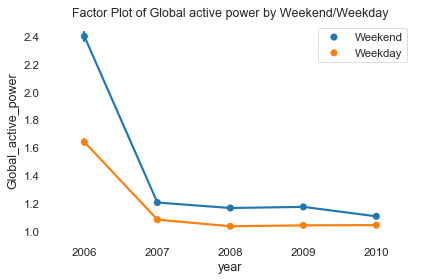

In [34]:
plt1=sns.factorplot('year','Global_active_power',hue='Day',
                    data=df, size=4, aspect=1.5, legend=False)                                                                                                                                                                                                                                                                                                                                             
plt.title('Factor Plot of Global active power by Weekend/Weekday')                                                             
plt.tight_layout()                                                                                                                  
sns.despine(left=True, bottom=True) 
plt.legend(loc='upper right');

- 신경망을 사용할 때는 시계열 데이터가 stationary일 필요는 없다. 그러나 시불변성이면 성능은 좋게 나타난다.
- 시불변성 데이터는 일정한 평균과 분산을 갖는다.
- 테스트는 Dickey–Fuller 테스트 사용

## Dickey-Fuller test
- Null Hypothesis (H0): It suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

- Alternate Hypothesis (H1): It suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

- p-value > 0.05: Accept the null hypothesis (H0), the data has a unit root and is non-stationary.

- p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

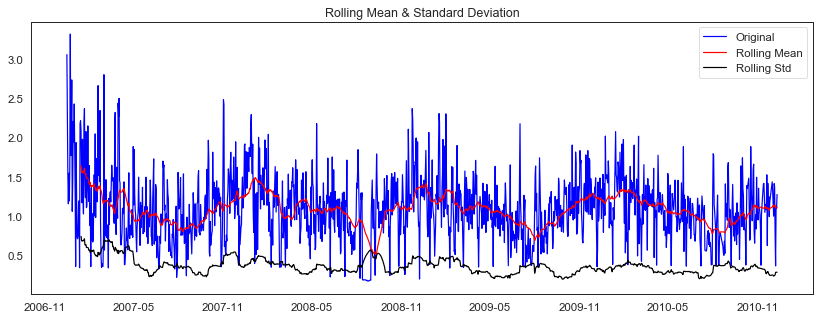

<Results of Dickey-Fuller Test>
Test Statistic                  -8.3277
p-value                          0.0000
#Lags Used                       9.0000
Number of Observations Used   1423.0000
Critical Value (1%)             -3.4350
Critical Value (5%)             -2.8636
Critical Value (10%)            -2.5679
dtype: float64


In [36]:
df2=df1.resample('D', how=np.mean)

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(df2.Global_active_power.dropna())


- 결론은 귀무가설을 기각하고, 대립가설을 받아들여 시불변성을 있다고 판단한다.

## LSTM 사용
- 분단위 데이터를 그대로 사용하거나, 시간 단위로 재샘플 할 수도 있다. (계산량을 줄일 수 있다)
### 전처리
- Create the dataset, ensure all data is float.
- Normalize the features.
- Split into training and test sets.
- Convert an array of values into a dataset matrix.
- Reshape into X=t and Y=t+1.
- Reshape input to be 3D (num_samples, num_timesteps, num_features).


In [37]:
dataset = df.Global_active_power.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [52]:
train_size, test_size, train_size+test_size, dataset.shape

(1639424, 409856, 2049280, (2049280, 1))

In [53]:
X_train.shape[0], X_test.shape[0], X_train.shape[0]+ X_test.shape[0]

(1639393, 409825, 2049218)

## 데이터 크기를 1/20로 줄여서 테스트 (100,000샘플)

In [60]:
new_dataset = dataset[:100000]
train_size = int(len(new_dataset) * 0.80)
test_size = len(new_dataset) - train_size
train, test = new_dataset[0:train_size,:], new_dataset[train_size:len(new_dataset),:]

X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [61]:
train_size, test_size, train_size+test_size, new_dataset.shape

(80000, 20000, 100000, (100000, 1))

In [62]:
X_train.shape[0], X_test.shape[0], X_train.shape[0]+ X_test.shape[0]

(79969, 19969, 99938)

## Model Architecture
- 유닛수: 100 neurons in the first hidden layer
- 출력층: 1 뉴런 (회귀)
- 입력: 1 time step with 30 features.
- Dropout 20%.
- 손실함수 MSE, Adam version of stochastic gradient descent.
- 20 training epochs with a batch size of 70


In [63]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=20, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()

Train on 79969 samples, validate on 19969 samples
Epoch 1/20
79969/79969 [==============================] - 6s 70us/step - loss: 0.0024 - val_loss: 0.0011
Epoch 2/20
79969/79969 [==============================] - 5s 60us/step - loss: 0.0015 - val_loss: 0.0012
Epoch 3/20
79969/79969 [==============================] - 5s 61us/step - loss: 0.0014 - val_loss: 0.0011
Epoch 4/20
79969/79969 [==============================] - 5s 57us/step - loss: 0.0013 - val_loss: 0.0011
Epoch 5/20
79969/79969 [==============================] - 5s 57us/step - loss: 0.0014 - val_loss: 0.0011
Epoch 6/20
79969/79969 [==============================] - 5s 58us/step - loss: 0.0013 - val_loss: 0.0011
Epoch 7/20
79969/79969 [==============================] - 5s 63us/step - loss: 0.0013 - val_loss: 0.0011
Epoch 8/20
79969/79969 [==============================] - 5s 59us/step - loss: 0.0013 - val_loss: 0.0010
Epoch 9/20
79969/79969 [==============================] - 4s 56us/step - loss: 0.0013 - val_loss: 0.0010
Epoch

In [64]:
# 예측
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))


Train Mean Absolute Error: 0.1884536052190037
Train Root Mean Squared Error: 0.38728752120780635
Test Mean Absolute Error: 0.1612287183888191
Test Root Mean Squared Error: 0.3328867422387961


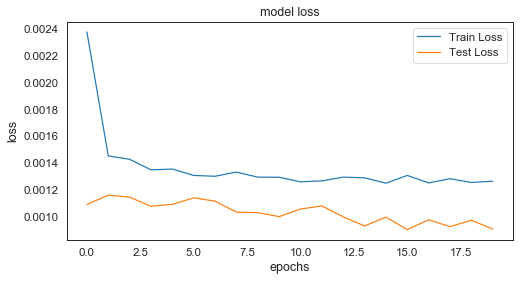

In [65]:
# 손실함수
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();


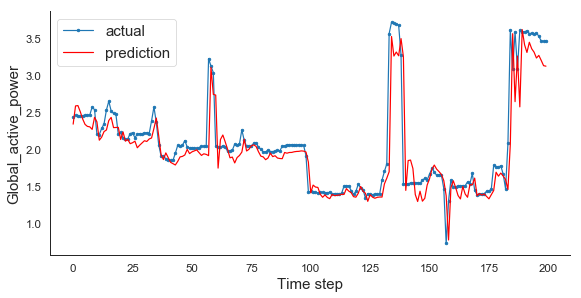

In [66]:
# 200 분간의 예측값, 실제값 비교
aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();